<a href="https://colab.research.google.com/github/pieva/SimPy/blob/main/Cascade_Switches_2023_08_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of the cascade of 2 switches


## Classes definition


In [ ]:
!pip install simpy

import simpy

### Ref: https://www.grotto-networking.com/DiscreteEventPython.html

""" A very simple class that represents a packet.
    This packet will run through a queue at a switch output port.
"""
class Packet(object):
    # Constructor method (initializer) for the Packet class.
    # It is called when a new instance of the class is created
    def __init__(self, time, size, id):
        # Sets the attributes of the packet object to the values provided as the arguments
        self.time = time       # the time the packet arrives at the output queue.
        self.size = size       # the size of the packet in bytes
        self.id = id           # an identifier for the packet

    # String representation method for the Packet class.
    # It defines what string will be returned when you call repr(packet) for a Packet object
    def __repr__(self):
        return "id: {}, time: {}, size: {}".\
            format(self.id, self.time, self.size)


""" Packet Generator with given inter-arrival time distribution.
    Set the "out" member variable to the entity to receive the packet.
"""
class PacketGenerator(object):
    # Constructor method: called when a new instance of the class is created,
    # it initializes the attributes of the packet generator object based on the provided arguments
    def __init__(self, env, arr_dist, size_dist, finish=float("inf")):
        self.env = env
        self.arr_dist = arr_dist    # inter-arrival times of the packets
        self.size_dist = size_dist    # sizes of the packets
        self.finish = finish  # stops generation at the finish time. Default is infinite
        self.out = None
        self.packets_sent = 0 # packets counter
        self.action = env.process(self.run())  # starts the run() method as a SimPy process

    # It is the generator function executed as a SimPy process when the simulation environment runs
    def run(self):
        # Start a loop that continues packet generation until the simulation time reaches the finish time
        while self.env.now < self.finish:
            # Yields control to the simulation environment for a duration determined by the value returned from the arr_dist() function.
            yield self.env.timeout(self.arr_dist())

            self.packets_sent += 1 # increment the packets_sent attribute to track the total number of packets generated

            # Creates a new Packet object with
            packet_size = int(self.size_dist())  # Convert the floating-point size to an integer
            p = Packet(self.env.now, packet_size, self.packets_sent)

            # This line sends the generated packet p to the entity represented by the out attribute,
            self.out.put(p)


""" Switch output port with a given rate and buffer size limit in bytes.
    Set the "out" member variable to the entity to receive the packet.
"""
class SwitchPort(object):
    # Constructor method
    def __init__(self, env, ps, rate, qlimit=None, limit_bytes=True, debug=False):
        self.env = env
        self.store = simpy.Store(env)  # simpy.Store object will act as a buffer for packets waiting to be processed by the switch port.
        self.rate = rate               # the bit rate of the port
        self.packets_rec = 0           # total number of packets received
        self.packets_drop = 0          # total number of packets dropped
        self.qlimit = qlimit           # buffer size limit in bytes or packets for the queue (including items in service).
        self.limit_bytes = limit_bytes # If true, the queue limit will be based on bytes, packets if false
        self.byte_size = 0             # Current size of the queue in bytes
        self.busy = 0                  # Used to track if a packet is currently being sent
        self.ps = ps                   # The packet sink object
        self.out = None                # the entity (e.g., another switch or a packet sink) to which the switch port sends packets
        self.debug = debug

        self.action = env.process(self.run())  # starts the run() method as a SimPy process

    # Behavior of the switch port
    def run(self):
        # Set the out attribute to the packet sink object
        self.out = self.ps
        while True:
            # Wait for a packet to be available in the store. When a packet is available, it is received and stored in the variable msg.
            msg = (yield self.store.get())

            self.busy = 1                                  # The switch port is currently processing a packet
            self.byte_size -= msg.size                     # Adjust the size of the available queue
            yield self.env.timeout(msg.size*8.0/self.rate) # Yield control to the environment waiting for the transmission time based on the bit rate
            self.out.put(msg)                              # Send the processed packet to the entity represented by the out attribute
            self.busy = 0                                  # Switch port has finished processing the packet and is ready to receive the next one

            # If in debug mode, print information about the processed packet msg.
            if self.debug:
                print(msg)

    # This method allows external entities to put (send) a packet into the switch port
    def put(self, pkt):
        self.packets_rec += 1                         # Track the total number of packets received by the switch port
        tmp_byte_count = self.byte_size + pkt.size    # Calculate the temporary byte count of the queue

        # Decide whether to put the packet into the queue or drop it
        if self.qlimit is None: # no buffer limit
            self.byte_size = tmp_byte_count
            return self.store.put(pkt)
        if self.limit_bytes and tmp_byte_count >= self.qlimit: # drop counting bytes
            self.packets_drop += 1
            return
        elif not self.limit_bytes and len(self.store.items) >= self.qlimit-1: # drop counting packets
            self.packets_drop += 1
        else:
            self.byte_size = tmp_byte_count # process the packet
            return self.store.put(pkt)


""" Receives packets and collects delay information into the
    waits list. You can then use this list to look at delay statistics.
"""
class PacketSink(object):
    # Constructor method
    def __init__(self, env, rec_arrivals=False, absolute_arrivals=False, rec_waits=True, debug=False):
        self.env = env
        self.store = simpy.Store(env)    # buffer to hold the incoming packets
        self.rec_waits = rec_waits       # If it is True, the waiting time for each packet will be recorded
        self.rec_arrivals = rec_arrivals # If it is True, the arrival times will be recorded
        self.absolute_arrivals = absolute_arrivals # True: absolute arrival times is recorded; False: time between consecutive arrivals
        self.waits = []                  # empty list to be used to store the waiting time
        self.arrivals = []               # empty list to be used to store arrival times
        self.debug = debug               # if true then the contents of each packet will be printed as it is received
        self.packets_rec = 0             # total number of packets received
        self.bytes_rec = 0               # total size of all packets received
        self.last_arrival = 0.0          # keeps track of the time of the last packet arrival to calculate inter-arrival times.
        self.out = None                  # Set the out attribute to the SwitchPort object

    # This method allows external entities to put a packet into the packet sink.
    def put(self, pkt):
            now = self.env.now
            #  If rec_waits is True, append the waiting time to the waits list
            if self.rec_waits:
                self.waits.append(self.env.now - pkt.time)
                pkt.time = now # reset packet time to the arrival time

            # the absolute or inter-arrival time is appended to the arrivals
            if self.rec_arrivals:
                if self.absolute_arrivals:
                    self.arrivals.append(now)
                else:
                    self.arrivals.append(now - self.last_arrival)
                self.last_arrival = now

            # Store the packet in the packet sink
            self.store.put(pkt)

            # track the total number of packets received
            self.packets_rec += 1

            # track the total size of all packets received
            self.bytes_rec += pkt.size

            # Send the packet to the entity represented by the out attribute
            if self.out is not None:
                self.out.put(pkt)  # Add this line to propagate the packet to the output entity

            if self.debug:
                print(pkt)


""" A monitor for an SwitchPort. Looks at the number of items in the SwitchPort
    in service + in the queue and records that info in the sizes[] list. The
    monitor looks at the port at time intervals given by the distribution dist.
"""
class PortMonitor(object):
    # constructor method
    def __init__(self, env, port, dist, count_bytes=False):
        self.env = env
        self.port = port # the switch port object to be monitored.
        self.dist = dist # inter-arrival times of the packets, used to schedule the times at which the monitor checks the queue size
        self.count_bytes = count_bytes
        self.sizes = [] # list to store the number of bytes/packets in the output port at different time points
        self.times = []  # list to store the time points at which the queue size is recorded

        self.action = env.process(self.run())

    # periodically check and record the queue size in the switch output port
    def run(self):
        while True:
            yield self.env.timeout(self.dist())
            if self.count_bytes:
                total = self.port.byte_size
            else:
                total = len(self.port.store.items) + self.port.busy
            self.sizes.append(total)
            self.times.append(self.env.now)  # record the current simulation time


## Main

In [ ]:
import random
import functools

# Set a specific seed value to make the random selection replicable
seed_value = 42
random.seed(seed_value)

# Set up arrival and packet size distributions
arr_dist  = functools.partial(random.expovariate, 0.5)   # generator inter-arrival times
size_dist = functools.partial(random.expovariate, 0.01)  # generator mean size 100 bytes
port_rate = 1000.0 # switch port rate
qlimit=10000       # switch buffer size
samp_dist = functools.partial(random.expovariate, 1.0) # times at which the monitor checks the queue size

# Create the SimPy environment
env = simpy.Environment()

# Create the network nodes
pg = PacketGenerator(env, arr_dist, size_dist)
ps_1 = PacketSink(env, rec_arrivals=True, absolute_arrivals=True, rec_waits=True, debug=False)
ps_2 = PacketSink(env, rec_arrivals=True, absolute_arrivals=True, rec_waits=True, debug=False)
switch_1 = SwitchPort(env, ps_1, port_rate, qlimit, debug=False)
switch_2 = SwitchPort(env, ps_2, port_rate, qlimit, debug=False)

# Wire network nodes together
pg.out = switch_1
switch_1.out = ps_1
ps_1.out = switch_2
switch_2.out = ps_2

# Using PortMonitors to track queue sizes over time for both switches
pm_1 = PortMonitor(env, switch_1, samp_dist)
pm_2 = PortMonitor(env, switch_2, samp_dist)

# Run the simulation
env.run(until=500)


## Print statistics

In [ ]:
# Calculate and Print Delay Statistics
total_delay = sum(ps_1.waits) + sum(ps_2.waits)
average_delay = total_delay / (ps_1.packets_rec + ps_2.packets_rec)
max_delay = max(ps_1.waits + ps_2.waits)
min_delay = min(ps_1.waits + ps_2.waits)

print("Delay Statistics")
print("Average Packet Delay: {:.2f} time units".format(average_delay))
print("Maximum Packet Delay: {:.2f} time units".format(max_delay))
print("Minimum Packet Delay: {:.2f} time units".format(min_delay))
print("Total Delay: {:.2f} time units".format(total_delay))

# Calculate Average Queue Size in the Simulation
average_queue_size_switch_1_simulation = sum(pm_1.sizes) / len(pm_1.sizes)
average_queue_size_switch_2_simulation = sum(pm_2.sizes) / len(pm_2.sizes)

# Calculate Expected Queue Size in M/M/1 Queue
arrival_rate = (ps_1.packets_rec + ps_2.packets_rec) / env.now
service_rate = port_rate / 8.0  # Convert port rate from bits/s to bytes/time_unit
expected_queue_size_mm1 = arrival_rate / (service_rate - arrival_rate)

# Print the Queue Size Statistics
print("\nQueue Size Statistics")
print("Average Queue Size in the Simulation:")
print("Switch 1: {:.2f} packets".format(average_queue_size_switch_1_simulation))
print("Switch 2: {:.2f} packets".format(average_queue_size_switch_2_simulation))

print("\nExpected Queue Size in M/M/1 Model: {:.2f} packets".format(expected_queue_size_mm1))


Delay Statistics
Average Packet Delay: 1.21 time units
Maximum Packet Delay: 6.73 time units
Minimum Packet Delay: 0.00 time units
Total Delay: 578.98 time units

Queue Size Statistics
Average Queue Size in the Simulation:
Switch 1: 0.53 packets
Switch 2: 0.58 packets

Expected Queue Size in M/M/1 Model: 0.01 packets


## Display packet tables

In [ ]:
# Print a table for packets in both switches

print("\nSwitch 1:")
print("Packet ID\tPacket Size\tQueue Size\tArrival Time\tWaiting Time\tDeparture Time")
for packet_id, (queue_size, arrival_time, waiting_time, packet) in enumerate(zip(pm_1.sizes, ps_1.arrivals, ps_1.waits, ps_1.store.items), start=1):
    departure_time = arrival_time + waiting_time
    print(f"{packet_id}\t\t{packet.size}\t\t{queue_size}\t\t{arrival_time:.6f}\t\t{waiting_time:.6f}\t\t{departure_time:.6f}")

print("\nSwitch 2:")
print("Packet ID\tPacket Size\tQueue Size\tArrival Time\tWaiting Time\tDeparture Time")
for packet_id, (queue_size, arrival_time, waiting_time, packet) in enumerate(zip(pm_2.sizes, ps_2.arrivals, ps_2.waits, ps_2.store.items), start=1):
    departure_time = arrival_time + waiting_time
    print(f"{packet_id}\t\t{packet.size}\t\t{queue_size}\t\t{arrival_time:.6f}\t\t{waiting_time:.6f}\t\t{departure_time:.6f}")



Switch 1:
Packet ID	Packet Size	Queue Size	Arrival Time	Waiting Time	Departure Time
1		3		0		2.064121		0.024000		2.088121
2		2		0		2.549554		0.016000		2.565554
3		78		0		3.600937		0.624000		4.224937
4		88		0		4.304937		0.829947		5.134884
5		92		0		7.526466		0.736000		8.262466
6		176		0		11.489926		1.408000		12.897926
7		86		1		12.697319		0.688000		13.385319
8		31		0		14.695978		0.248000		14.943978
9		149		0		21.158283		1.192000		22.350283
10		3		0		21.182283		0.695741		21.878025
11		23		0		21.428538		0.184000		21.612538
12		24		0		27.162781		0.192000		27.354781
13		208		0		40.648023		1.664000		42.312023
14		19		0		40.800023		1.204609		42.004633
15		75		0		45.070571		0.600000		45.670571
16		39		1		45.382571		0.910856		46.293427
17		264		1		47.494571		2.983518		50.478089
18		142		0		49.866391		1.136000		51.002391

Switch 2:
Packet ID	Packet Size	Queue Size	Arrival Time	Waiting Time	Departure Time
1		3		0		2.088121		0.024000		2.112121
2		2		0		2.565554		0.016000		2.581554
3		78		1		4.224

## Plot time series

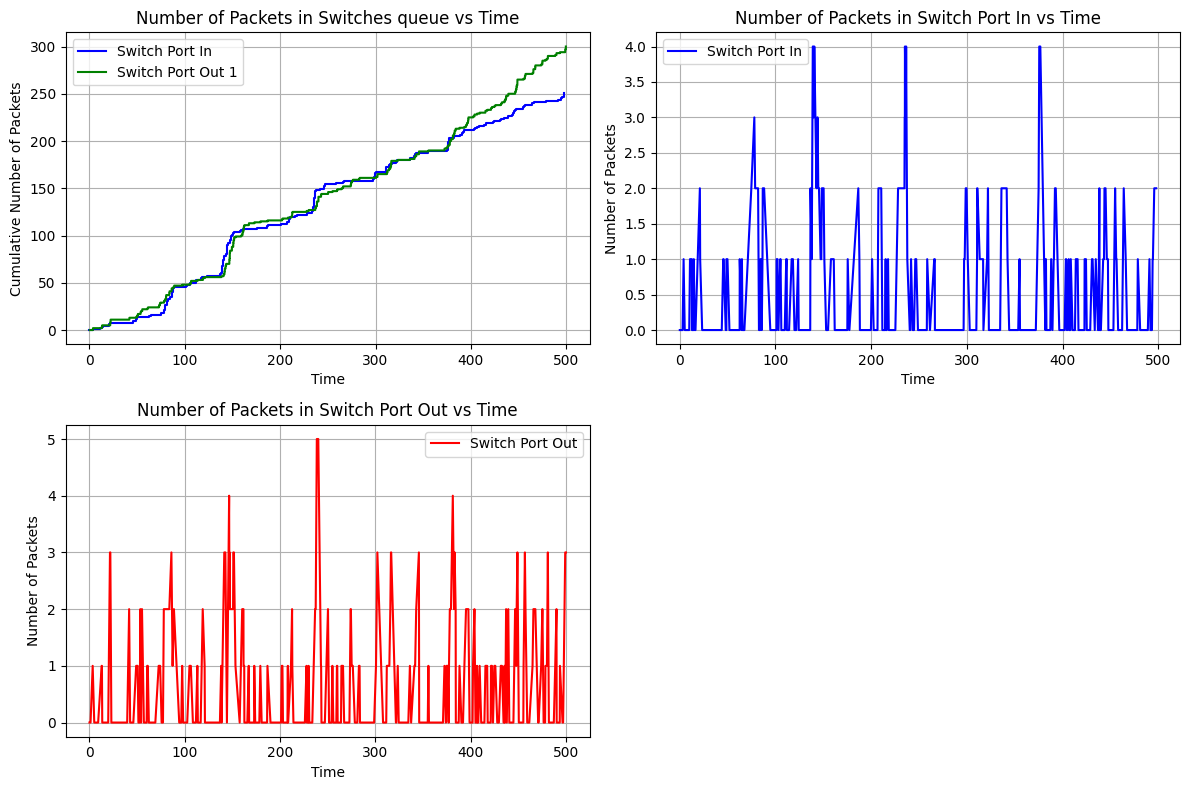

In [ ]:
import matplotlib.pyplot as plt
from itertools import accumulate

# Get the time points for each recorded size in PortMonitor
time_points_1 = pm_1.times
cumulative_packets_1 = list(accumulate(pm_1.sizes))

time_points_2 = pm_2.times
cumulative_packets_2 = list(accumulate(pm_2.sizes))


# Plotting the number of packets in the switches vs time
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.step(time_points_1, cumulative_packets_1, where='post', label='Switch Port In', color='blue')
plt.step(time_points_2, cumulative_packets_2, where='post', label='Switch Port Out 1', color='green')
plt.xlabel('Time')
plt.ylabel('Cumulative Number of Packets')
plt.title('Number of Packets in Switches queue vs Time')
plt.legend()
plt.grid(True)

# Plotting the packets for each switch
plt.subplot(2, 2, 2)
plt.plot(time_points_1, pm_1.sizes, label='Switch Port In', color='blue')
plt.xlabel('Time')
plt.ylabel('Number of Packets')
plt.title('Number of Packets in Switch Port In vs Time')
plt.legend()
plt.grid(True)

# Plotting the arrival distributions for the switches
plt.subplot(2, 2, 3)
plt.plot(time_points_2, pm_2.sizes, label='Switch Port Out', color='red')
plt.xlabel('Time')
plt.ylabel('Number of Packets')
plt.title('Number of Packets in Switch Port Out vs Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
